In [1]:
#!pip install --upgrade tf_slim

import gym
import tensorflow as tf
import tensorflow.contrib.slim as slim
import tf_slim as slim
import numpy.random as rnd
import numpy as np
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow import keras
from collections import deque # container em forma de lista, com rapida insercao e remocao nas duas extremidades 
from ns3gym import ns3env

#from sklearn.preprocessing import label_binarize
#from keras.layers import Dense, Flatten, Reshape

/home/sheila/anaconda3/envs/environment_py3_7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sheila/anaconda3/envs/environment_py3_7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sheila/anaconda3/envs/environment_py3_7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sheila/

In [2]:
seed = 32
np.random.seed(seed)
tf.random.set_random_seed(seed)#tf.random.set_seed(seed)
random.seed(seed)

In [3]:
env = gym.make('ns3-v0') # environment ID 

ob_space = env.observation_space
ac_space = env.action_space
print("Observation space: ", ob_space,  ob_space.dtype)
print("Action space: ", ac_space, ac_space.dtype)

# numero de estados
state_size = ob_space.shape[0]

# numero de acoes
action_size = ac_space.shape[0]

print("\n")
print("Numero de Estados: ", state_size)
print("Numero de Acoes: ", action_size) 

Got new port for ns3gm interface:  5635
Observation space:  Box(0, 100, (5,), uint64) uint64
Action space:  Box(0, 100, (5,), uint64) uint64


Numero de Estados:  5
Numero de Acoes:  5


In [4]:
numOfEpisodes = 400 #300 #200
numTimeSlots = 1000 #600 #495

discount_rate = 0.75 # gamma 0.618; 0.528; 0.95---- 70 e decay = 0.9999 graph points meet
learning_rate = 0.75 # Learning rate 0.7


# Epsilon greedy parameters
epsilon = 1 # Epsilon-greedy algorithm in initialized at 1 meaning every step is random at the start
max_epsilon = 1 # You can't explore more than 100% of the time
min_epsilon = 0.01 # At a minimum, we'll always explore 1% of the time
decay = 0.999999#0.01
epsilon_vec = np.zeros((numOfEpisodes,))

maxNofCollisions = 3

batch_size = 128 # tamanho do batch 128

MIN_REPLAY_SIZE = 1000 # tamanho minimo da memoria de repeticao

inputQueues = 5
cwSize = 100

In [5]:
def createModel(inputQueues, cwSize, loss='mse'):
    learning_rate = 0.01 #0.01
    init = tf.keras.initializers.he_uniform()#tf.keras.initializers.HeUniform()
    model = keras.Sequential()
    # Input layer - número dos estados de entrada 
    model.add(keras.layers.Dense(inputQueues, input_shape=(inputQueues,), activation='relu', kernel_initializer=init))
    # Output layer - número de ações no ambiente
    model.add(keras.layers.Dense(cwSize, activation='linear', kernel_initializer=init))
    #model.add(keras.layers.Flatten())
    
    if(loss=='huber'):
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=tf.keras.losses.Huber(), metrics=['accuracy'])
        print('Using Huber loss...', "\n")
    elif(loss=='mse'):
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse', metrics=['accuracy'])
        print('Using MSE loss...', "\n")
    else:
        print('Loss not defined...', "\n")
    return model

def train(replay_memory, model, model_target, done, batch_size, acc_history=[], loss_history=[]):
    mini_batch = random.sample(replay_memory, batch_size)
    c_states = np.array([transition[0] for transition in mini_batch])    
    #print("CSTATES", c_states, c_states.shape)
    current_qs_list  = model.predict(c_states)
    n_states = np.array([transition[3] for transition in mini_batch]) 
    future_qs_list = model_target.predict(n_states)
    
    
    X = []
    Y = []
    for index, (c_state, actionVec, reward, n_state, done) in enumerate(mini_batch):
        
        if not done:
            max_future_q = reward + discount_rate * np.max(future_qs_list[index])
        else:
            max_future_q = reward

        
        current_qs = current_qs_list[index]
        #print("heyyyy")
        #action != 100
        for action in actionVec:
            if(action != 100):
                current_qs[action] = max_future_q

        X.append(c_state)
        Y.append(current_qs)

    # Train model with a mini-batch.
    history = model.fit(np.array(X), np.array(Y), batch_size=batch_size, verbose=0, shuffle=True)

    # Store metrics.
    acc_history.append(history.history['acc'][0])
    loss_history.append(history.history['loss'][0])

    return history

In [6]:
print("Prediction Network")
# The first model makes the predictions for Q-values which are used to make a action.
model = createModel(inputQueues, cwSize)

print("Target Network")
# Build a target model for the prediction of future rewards.
model_target = createModel(inputQueues, cwSize)
# Initialize target model's weights.
model_target.set_weights(model.get_weights())

Prediction Network
Using MSE loss... 

Target Network
Using MSE loss... 



In [7]:
model.metrics_names

['loss', 'acc']

In [8]:
acc_history = []
loss_history = []

episode_reward = np.zeros((numOfEpisodes,))
max_reward =  np.zeros((numOfEpisodes,))
replay_memory = deque(maxlen=50_000)

steps_to_update_target_model = 0


for episode in range(numOfEpisodes):
    
        
    print('Episode:', episode)

    collisionCnt = 0
    
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    #state = np.array(state)
    
                       
    for iteration in range(numTimeSlots):
        
                        
        steps_to_update_target_model += 1
        
        #print("Time Slot   :", iteration)
        #print("----------------------")
        
        #print("Estado atual:", state[0])
                  
        # Escolha da ação.
        if np.random.uniform() >= epsilon:
            #predicted = model.predict(state.reshape(1,4))
            #action = np.argmax(predicted[0])
            
            act = model.predict(state)
            #print("actions ", act, act[0][0], act[0][1], act[0][2], act[0][3], act[0][4])
            act = act.reshape(20,5)
            
            action0 = np.argmax(act[:,0])            
            action1 = np.argmax(act[:,1])
            action2 = np.argmax(act[:,2])
            action3 = np.argmax(act[:,3])
            action4 = np.argmax(act[:,4])
            #action0 = np.argmax(model.predict(state[:,0]-state[:,1])[0])
            #action1 = np.argmax(model.predict(state[:,1]-state[:,2])[0])
            #action2 = np.argmax(model.predict(state[:,2]-state[:,3])[0])
            #action3 = np.argmax(model.predict(state[:,3]-state[:,4])[0])
            #action4 = np.argmax(model.predict(state[:,4]-state[:,5])[0])
            
            #print("Action (Q)") # action0, action1, action2, action3
        else:
            action0 = np.random.randint(1, cwSize)
            action1 = np.random.randint(1, cwSize)
            action2 = np.random.randint(1, cwSize)
            action3 = np.random.randint(1, cwSize)
            action4 = np.random.randint(1, cwSize)
            #print("Action (rnd)") # action0, action1, action2, action3
            
        
        actionVec = [action0, action1, action2, action3, action4]
        #print("ActionVec   :", actionVec)
        
        next_state, reward, done, _, _ = env.step(actionVec)
        
        #print("reward: ", reward)
      
        next_state = np.reshape(next_state, [1, state_size])
        #next_state = np.reshape(next_state, [state_size, ])
        #next_state = np.array(next_state)
        #print("Next State  :", next_state[0])
        
        #print("Reward      : ", reward)
        
        # Reward.
        if ((actionVec[3] >= 10) and (actionVec[4] >= 10)):
            reward = 0.0
            collisionCnt += 1
        else:
            reward = 1.0
        
        # Add information to replay buffer.
        replay_memory.append([state[0], actionVec, reward, next_state[0], done])          

        # Accumulate reward.
        #if (reward!=0.0):
        episode_reward[episode] += reward
        #episode_reward[episode] += reward
        #print("episode_reward[episode]:", episode_reward[episode])
      
        # Plot received reward.
        #print("Reward      :", reward)
        #print("-------------", "\n")      

        
        
        # Train
        if len(replay_memory) >= MIN_REPLAY_SIZE:
            
            history = train(replay_memory, model, model_target, done, batch_size, acc_history, loss_history)

        # Is it the end of the episode?
        if done:
            #print("Done: ", done)
            collisionCnt = 0
            # Update the the target network with new weights
            model_target.set_weights(model.get_weights())
            #print('########## Game Over ##########')
            break
        
        # updates the current state
        state = next_state
        
    # Decrease epsilon along the way.
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay * episode)
    epsilon_vec[episode] = epsilon 
        
    # Store maxmim possible reward per episode.
    #max_reward[episode] = iteration + 1
    max_reward[episode] = iteration + 1 #reward + 1 
    #print("max_reward[episode]", max_reward[episode])
        
    print('episode_reward:', episode_reward[episode])

Episode: 0
currentNodeId=4
episode_reward: 48.0
Episode: 1
currentNodeId=4
Got new port for ns3gm interface:  6750
episode_reward: 49.0
Episode: 2
currentNodeId=4
Got new port for ns3gm interface:  6185
episode_reward: 189.0
Episode: 3
currentNodeId=4
Got new port for ns3gm interface:  7484
episode_reward: 266.0
Episode: 4
currentNodeId=4
Got new port for ns3gm interface:  9668
episode_reward: 270.0
Episode: 5
currentNodeId=4
Got new port for ns3gm interface:  7319
episode_reward: 294.0
Episode: 6
currentNodeId=4
Got new port for ns3gm interface:  8525
episode_reward: 300.0
Episode: 7
currentNodeId=4
Got new port for ns3gm interface:  8338
episode_reward: 276.0
Episode: 8
currentNodeId=4
Got new port for ns3gm interface:  7547
episode_reward: 229.0
Episode: 9
currentNodeId=4
Got new port for ns3gm interface:  6979
episode_reward: 308.0
Episode: 10
currentNodeId=4
Got new port for ns3gm interface:  5823
episode_reward: 240.0
Episode: 11
currentNodeId=4
Got new port for ns3gm interface: 

episode_reward: 217.0
Episode: 93
currentNodeId=4
Got new port for ns3gm interface:  7426
episode_reward: 87.0
Episode: 94
currentNodeId=4
Got new port for ns3gm interface:  8789
episode_reward: 209.0
Episode: 95
currentNodeId=4
Got new port for ns3gm interface:  6516
episode_reward: 153.0
Episode: 96
currentNodeId=4
Got new port for ns3gm interface:  8383
episode_reward: 126.0
Episode: 97
currentNodeId=4
Got new port for ns3gm interface:  8071
episode_reward: 129.0
Episode: 98
currentNodeId=4
Got new port for ns3gm interface:  7680
episode_reward: 26.0
Episode: 99
currentNodeId=4
Got new port for ns3gm interface:  8970
episode_reward: 165.0
Episode: 100
currentNodeId=4
Got new port for ns3gm interface:  9675
episode_reward: 228.0
Episode: 101
currentNodeId=4
Got new port for ns3gm interface:  9277
episode_reward: 218.0
Episode: 102
currentNodeId=4
Got new port for ns3gm interface:  8559
episode_reward: 74.0
Episode: 103
currentNodeId=4
Got new port for ns3gm interface:  5406
episode_r

episode_reward: 288.0
Episode: 184
currentNodeId=4
Got new port for ns3gm interface:  7274
episode_reward: 190.0
Episode: 185
currentNodeId=4
Got new port for ns3gm interface:  9182
episode_reward: 385.0
Episode: 186
currentNodeId=4
Got new port for ns3gm interface:  6325
episode_reward: 381.0
Episode: 187
currentNodeId=4
Got new port for ns3gm interface:  5129
episode_reward: 345.0
Episode: 188
currentNodeId=4
Got new port for ns3gm interface:  7948
episode_reward: 307.0
Episode: 189
currentNodeId=4
Got new port for ns3gm interface:  9898
episode_reward: 381.0
Episode: 190
currentNodeId=4
Got new port for ns3gm interface:  7128
episode_reward: 339.0
Episode: 191
currentNodeId=4
Got new port for ns3gm interface:  6477
episode_reward: 387.0
Episode: 192
currentNodeId=4
Got new port for ns3gm interface:  9371
episode_reward: 294.0
Episode: 193
currentNodeId=4
Got new port for ns3gm interface:  6015
episode_reward: 271.0
Episode: 194
currentNodeId=4
Got new port for ns3gm interface:  6040

episode_reward: 289.0
Episode: 275
currentNodeId=4
Got new port for ns3gm interface:  6408
episode_reward: 338.0
Episode: 276
currentNodeId=4
Got new port for ns3gm interface:  6102
episode_reward: 343.0
Episode: 277
currentNodeId=4
Got new port for ns3gm interface:  5922
episode_reward: 347.0
Episode: 278
currentNodeId=4
Got new port for ns3gm interface:  6545
episode_reward: 340.0
Episode: 279
currentNodeId=4
Got new port for ns3gm interface:  5130
episode_reward: 281.0
Episode: 280
currentNodeId=4
Got new port for ns3gm interface:  9908
episode_reward: 340.0
Episode: 281
currentNodeId=4
Got new port for ns3gm interface:  6156
episode_reward: 328.0
Episode: 282
currentNodeId=4
Got new port for ns3gm interface:  8930
episode_reward: 295.0
Episode: 283
currentNodeId=4
Got new port for ns3gm interface:  5020
episode_reward: 251.0
Episode: 284
currentNodeId=4
Got new port for ns3gm interface:  6272
episode_reward: 256.0
Episode: 285
currentNodeId=4
Got new port for ns3gm interface:  7460

episode_reward: 156.0
Episode: 366
currentNodeId=4
Got new port for ns3gm interface:  6168
episode_reward: 201.0
Episode: 367
currentNodeId=4
Got new port for ns3gm interface:  6591
episode_reward: 385.0
Episode: 368
currentNodeId=4
Got new port for ns3gm interface:  7649
episode_reward: 126.0
Episode: 369
currentNodeId=4
Got new port for ns3gm interface:  7871
episode_reward: 151.0
Episode: 370
currentNodeId=4
Got new port for ns3gm interface:  5657
episode_reward: 365.0
Episode: 371
currentNodeId=4
Got new port for ns3gm interface:  8604
episode_reward: 291.0
Episode: 372
currentNodeId=4
Got new port for ns3gm interface:  8980
episode_reward: 111.0
Episode: 373
currentNodeId=4
Got new port for ns3gm interface:  5039
episode_reward: 214.0
Episode: 374
currentNodeId=4
Got new port for ns3gm interface:  8688
episode_reward: 257.0
Episode: 375
currentNodeId=4
Got new port for ns3gm interface:  6659
episode_reward: 139.0
Episode: 376
currentNodeId=4
Got new port for ns3gm interface:  6012

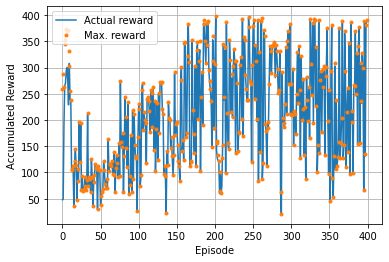

In [9]:
plt.plot(episode_reward, label='Actual reward')
plt.plot(max_reward, '.', label='Max. reward')
plt.xlabel('Episode')
plt.ylabel('Accumulated Reward')
plt.grid()
plt.legend()
plt.show()

In [ ]:
max_reward

In [ ]:
episode_reward

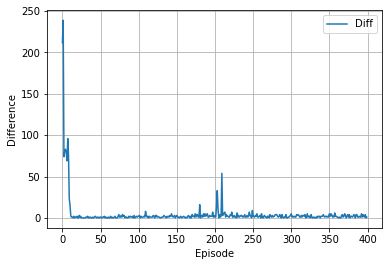

In [10]:
diff  = (max_reward - episode_reward)
plt.plot(diff, label='Diff')
plt.xlabel('Episode')
plt.ylabel('Difference')
plt.grid()
plt.legend()
plt.show()

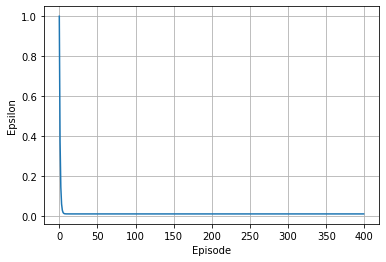

In [11]:
plt.plot(epsilon_vec)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.grid()
plt.show()

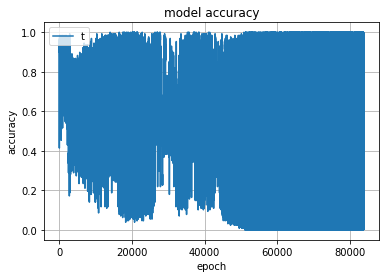

In [12]:
# summarize history for accuracy
plt.plot(acc_history)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend('train', loc='upper left')
plt.grid()
plt.show()

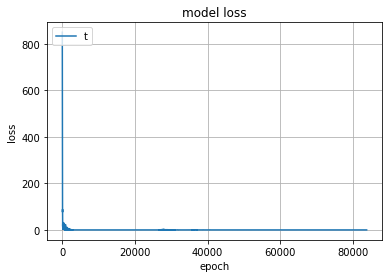

In [13]:
# summarize history for loss
plt.plot(loss_history)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend('train', loc='upper left')
plt.grid()
plt.show()